In [1]:
# Standard Python modules
import os, sys
import glob
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import textwrap
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, make_cmap, plot_maxmin_points
import nclcmaps as nclc
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date
from wrf_funcs_preprocess import calculate_WRF_vertical_cross_static

In [2]:
# Set up paths

path_to_data = '/home/sbarc/students/nash/data/HMA_freezing_level_data/'  # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures                       # figures



## Import AR Data

In [3]:
# Select lat/lon grid
lonmin = 60
lonmax = 115
latmin = 15
latmax = 60

## points of landslides (chosen in fig10_wvf_climatology-analysis.ipynb)
pt1 = [72.6625, 34.8733]
pt2 = [74.0225, 34.0876]
# Line1 = [latmin, lonmin, latmax, lonmax] 

line1 = [32., pt1[0], 35., pt1[0]]
line2 = [32., pt2[0], 35., pt2[0]]

newline = [line1, line2]
stars = [pt1[1], pt2[1]] # location of landslide in cross section

ds2_ext = [22.05, 40.33, 68.24, 99.12]

In [4]:
class cross_section:
    
    def __init__(self, arname, newline):
        self.arname = arname
    
        # import configuration file for case study choice
        yaml_doc = '../data/other/ar_casestudy.yml'
        config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
        ar_dict = config[self.arname]

        self.year = ar_dict['year']
        month = ar_dict['month']
        self.start_date = ar_dict['start_date']
        self.end_date = ar_dict['end_date']
        print(self.start_date, self.end_date)
        ar_ID = ar_dict['ar_ID']
        print(ar_ID)

        self.date_lst = pd.date_range(self.start_date, self.end_date, freq='1D')
        
        # unprocessed 6.7 km wrf filenames
        self.wrf_filenames = ar_dict['wrf_files']
        self.wrf_terrain_fname = ar_dict['wrf_files2'][0]
        
        self.newline = newline
        
        
    def load_2D_WRF_data(self):
        domains = ['d01', 'd01', 'd02', 'd01']
        varname_lst = ['ivt', 'geopotential', 'prec', 'zerodegisotherm']
        res_lst = ['3hr', '3hr', '3hr', '3hr']


        ## loop through each ds
        ds_lst = []
        for i, (dom, varname, res) in enumerate(zip(domains, varname_lst, res_lst)):

            if res == 'daily':
                fname = path_to_data + 'preprocessed/{1}/out.wrf.{0}.{1}.daily_{2}.nc'.format(dom, varname, self.year)
            else: 
                fname = path_to_data + 'dryad/{1}/out.wrf.{0}.{1}.3hr_{2}.nc'.format(dom, varname, self.year)
            print(fname)

            ds = xr.open_dataset(fname)

            # subset to just ar days
            ds = ds.sel(time = slice(self.start_date, self.end_date))

            if varname == 'ivt':
                ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
            if varname == 'geopotential':
                ds = ds.sel(lev=250.)
            if varname == 'prec':
                # Calculate precipitation rate
                ds['prec_new'] = ds.prec.shift(time=-1) - ds.prec # if in xarray

                # calculate snow and rain
                ds['snow'] = ds['prec_new']*ds['sr']
                ds['rain'] = ds['prec_new']*(1-ds['sr'])

            ## hack to select the time step of most intense IVT
            if (arname == 'feb1998') & (varname != 'prec') & (varname != 'sr'):
                # select the 06 UTC hour 
                ds = ds.sel(time=ds.time.dt.hour == 6)
            elif (arname == 'jan1989') & (varname != 'prec') & (varname != 'sr'):
                # select the 06 UTC hour 
                ds = ds.sel(time=ds.time.dt.hour == 12)
            elif (varname != 'prec') & (varname != 'sr'):
                # select the 00 UTC hour 
                ds = ds.sel(time=ds.time.dt.hour == 0)

            ds_lst.append(ds)


        # self.dates = ds_lst[0].time.values # get time values for cross sections
        
        return ds_lst
        
        
    def calculate_cross_section(self, date):
        

        varlst = ('pressure', 'theta_e', 'theta', 'rh', 'ua', 'va', 'wa', 'wspd', 'QVAPOR', 'z', 'omega', 'QSNOW')
        cross_lst = []
        for i, line in enumerate(self.newline):
            # hlat, hlon, tlat, tlon
            cross_lst.append(calculate_WRF_vertical_cross_static(self.wrf_filenames, varlst, date, line[0], line[1], line[2], line[3]))
        
        ## hacked this for now - not really sure how to index these cross sections
        ## get cross_idx of landslide loc
        cross_idx1 = cross_lst[0][0].cross_line_idx[-4].values
        cross_idx2 = cross_lst[1][0].cross_line_idx[-18].values

        cross_idx_lst = [cross_idx1, cross_idx2]
        # pt1 = [72.6625, 34.8733]
        # pt2 = [74.0225, 34.0876]        
        return cross_lst, cross_idx_lst

        
    def cross_interpolation(self):

        
        ## select single date that I want to plot
        if self.arname == 'jan1989':
            dateofinterest = '1989-01-05 12'
            dateofinterest_prec = '1989-01-05 00'
            # cross_new = [cross_lst[0][2], cross_lst[1][2]] # want third timestep in cross section
            cross_new = pd.to_datetime(dateofinterest, format='%Y-%m-%d %H')

        if self.arname == 'feb2010':
            dateofinterest = '2010-02-08 00'
            dateofinterest_prec = '2010-02-08 00'
            # cross_new = [cross_lst[0][-2], cross_lst[1][-2]] # want second to last timestep in cross section
            cross_new = pd.to_datetime(dateofinterest, format='%Y-%m-%d %H')
            
            
        wrfin = nc.Dataset(self.wrf_terrain_fname)
        terrain_d01 = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height
        
        wrfin = nc.Dataset(self.wrf_filenames[0])
        terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height
        terline = []
        for i, line in enumerate(self.newline):
            # Set the start point and end point for the cross section
            start_point = wrf.CoordPair(lat=line[0], lon=line[1])
            end_point = wrf.CoordPair(lat=line[2], lon=line[3])
            print(start_point, end_point)
            tmp = wrf.interpline(terrain, wrfin=wrfin, start_point=start_point, end_point=end_point, latlon=True)
            terline.append(tmp)
            
        ds_lst = self.load_2D_WRF_data()
            
        # sum precip for duration of event
        ds_prec = ds_lst[2].sum('time', skipna=True)

        # interpolate precipitation, snow, and freezing level across cross section line
        datalst = [ds_prec, ds_lst[3].sel(time=dateofinterest)]

        final_cross = []
        for i, data in enumerate(datalst):
            cross = []
            for j, ter in enumerate(terline):
                # get the along AR axis coord_pairs for that timestep
                coord_pairs = ter.coords["xy_loc"].values
                yvals = [pair.lat for pair in coord_pairs]
                xvals = [pair.lon for pair in coord_pairs]
                x = xr.DataArray(xvals, dims="z")
                y = xr.DataArray(yvals, dims="z")
                cross.append(data.interp(lon=x, lat=y))

            final_cross.append(cross)

        prec_crs = final_cross[0]
        freeze_crs = final_cross[1]
        
        # print prec values at specified location
        print(prec_crs[0].rain.isel(z=-4).values)
        print(prec_crs[0].snow.isel(z=-4).values)
        
        ## get cross section values
        print('Date/time of cross section is {0}'.format(cross_new))
        cross_lst, cross_idx_lst = self.calculate_cross_section([cross_new])
            
        ivt = ds_lst[0].sel(time=dateofinterest)
        z = ds_lst[1].sel(time=dateofinterest)
        prec_data = ds_lst[2].resample(time="1D").sum('time')
        prec = prec_data.prec_new.sel(time=dateofinterest_prec)
        
        
        return terrain_d01, ivt, z, prec, prec_crs, freeze_crs, cross_lst, cross_idx_lst
        

In [5]:
%%time
arcase_lst = ['jan1989', 'feb2010']
ivt_lst = []
z_lst = []
prec_lst = []
prec_crs_lst = []
freeze_crs_lst = []
cross_lst = []
cross_idx_lst = []

for i, arname in enumerate(arcase_lst):
    ## run cross section class to get vars to plot
    s = cross_section(arname, newline)
    terrain, ivt, z, prec, prec_crs, freeze_crs, cross, cross_idx = s.cross_interpolation()
    
    ivt_lst.append(ivt)
    z_lst.append(z)
    prec_lst.append(prec)
    prec_crs_lst.append(prec_crs)
    freeze_crs_lst.append(freeze_crs)
    cross_lst.append(cross)
    cross_idx_lst.append(cross_idx)
    
## hack to plot both cases on each figure
prec_crs = prec_crs_lst[0] + prec_crs_lst[1]
cross_new = cross_lst[0] + cross_lst[1]
freeze_crs = freeze_crs_lst[0] + freeze_crs_lst[1]

1989-01-03 1989-01-06
[31016]
CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
CoordPair(lat=32.0, lon=74.0225) CoordPair(lat=35.0, lon=74.0225)
/home/sbarc/students/nash/data/HMA_freezing_level_data/dryad/ivt/out.wrf.d01.ivt.3hr_1989.nc
/home/sbarc/students/nash/data/HMA_freezing_level_data/dryad/geopotential/out.wrf.d01.geopotential.3hr_1989.nc
/home/sbarc/students/nash/data/HMA_freezing_level_data/dryad/prec/out.wrf.d02.prec.3hr_1989.nc
/home/sbarc/students/nash/data/HMA_freezing_level_data/dryad/zerodegisotherm/out.wrf.d01.zerodegisotherm.3hr_1989.nc
5.316214
142.89618
Date/time of cross section is 1989-01-05 12:00:00
/home/sbarc/students/nash/data/HMA_freezing_level_data/dryad/WRF_norris/wrfout_d02_1989-01-05_03:00:00 timeidx is  3
CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
/home/sbarc/students/nash/data/HMA_freezing_level_data/dryad/WRF_norris/wrfout_d02_1989-01-05_03:00:00 timeidx is  3
CoordPair(lat=32.0, lon=74.0225) CoordPair(lat=35.0, 

## Plot Cross Sections

For a helpful tutorial on building a plotting grid using GridSpec - visit [this blog post](http://www.sc.eso.org/~bdias/pycoffee/codes/20160407/gridspec_demo.html).

In [6]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()       # map/destination 

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

# row_lbl = []
# for i in range(len(ivt_lst[0].time.values)):
#     date = ds_lst[0][0].time[i].values
#     t = pd.to_datetime(str(date)) 
#     timestring = t.strftime('%Y-%m-%d %H:00')
#     ttl = "({0}) ".format(letter_lst[i]) + timestring
#     row_lbl.append(ttl)

# get lats and lons for plotting for d01
lats = ivt_lst[0]['lat'].values
lons = ivt_lst[0]['lon'].values
ext = [lons.min(), lons.max()-21, lats.min(), lats.max()-15]
print(ext)

# get lats and lons for plotting for d02
lats2 = prec_lst[0]['lat'].values
lons2 = prec_lst[0]['lon'].values

# ext2 = ar_dict['ext2']
ext2 = [69.0, 82.0, 30.0, 40.]
# ext3 = ar_dict['ext3']
ext3 = [60.2, 93.0, 20.0, 45.]

# Set tick/grid locations for d02
dx2 = np.arange(round(lons2.min(), 0),round(lons2.max()+1, 0),2)
dy2 = np.arange(round(lats2.min(), 0),round(lats2.max()+1, 0),2)

## row labels
row_lbl = ['January 1989', 'February 2010']

[60.203857, 92.796142578125, 16.428108, 41.15325927734375]


In [7]:
def add_lines_and_points(ax, ter):
    # Contour Lines (terrain)
    terclevs=np.array([1000, 3000])
    terlons = terrain.XLONG.isel(south_north=0).values
    terlats = terrain.XLAT.isel(west_east=0).values
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    cster = ax.contour(terlons, terlats, ter.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    # add cross section lines
    for i, line in enumerate(newline):
        ax.plot([line[1], line[3]],
                    [line[0], line[2]], color='#FEBC11', marker="o",
                    transform=datacrs, zorder=3)
    
    return ax

## Plot most interesting time step for each case

1. Fig 8: IVT and WV flux
2. Fig 9: precipitation, frozen precipitation, and mixing ratios

Max line rain: 102.55142
Max line snow: 171.68918
Max line rain: 58.044914
Max line snow: 213.77426
Max line rain: 174.08342
Max line snow: 267.1844
Max line rain: 145.62947
Max line snow: 282.79572


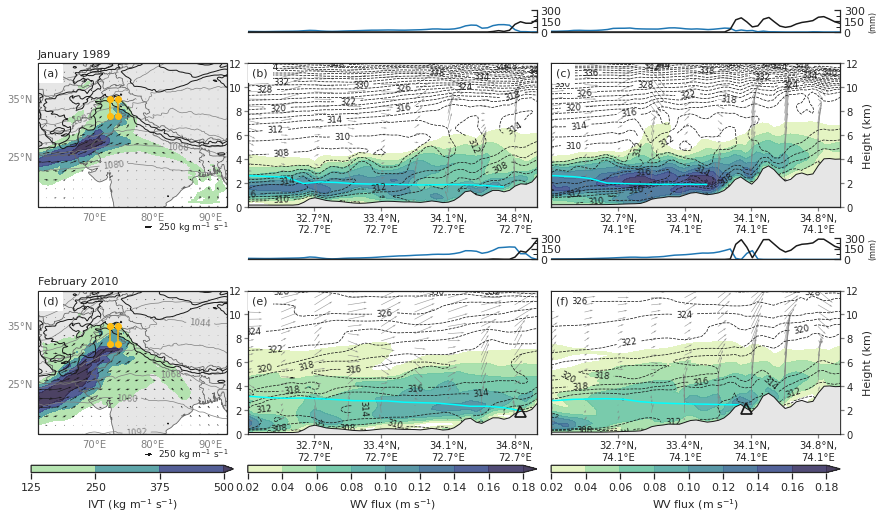

In [8]:
filepath = path_to_figs + 'cross-section_summary_IVT_WV-flux.png'
## five rows
## 1. precip line plots
## 2. Jan 1989 case 
## 3. precip line plot
## 4. Feb 2010 case
## 5. colorbars
nrows = 5
# three columns - 
## one for synoptic maps, 
## one for vertical cross sections along AR axis
## one for vertical cross sections across AR core
ncols = 3

# Create figure
fig = plt.figure(figsize=(14.5,8.5))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[0.15, 1, 0.15, 1, 0.05], width_ratios = [0.7, 1, 1], hspace=0.46, wspace=0.055)
## use gs[rows index, columns index] to access grids
# Now, create the gridspec structure, as required

#########################
### Precip line plots ###
#########################
latlon_lst = [12, 12, 12, 12]
row_idx = [0, 0, 2, 2]
col_idx = [1, 2, 1, 2]
for j, prec in enumerate(prec_crs):    
    ## Add rain and snow line plot
    ax = fig.add_subplot(gs[row_idx[j], col_idx[j]])

    # WRF Precip
    x = prec.lat.values
    y = prec.rain.values
    ax.plot(x, y, color='tab:blue')
    print('Max line rain:', np.nanmax(y))

    # WRF SNOW
    y = prec.snow.values
    ax.plot(x, y, color='k')
    print('Max line snow:', np.nanmax(y))

    # some plot parameters to make it look nice
    ax.set_ylim(0, 300)
    ax.set_yticks(np.arange(0, 375, 75))
    ax.yaxis.set_major_locator(plt.MultipleLocator(150))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(75))
    ax.yaxis.tick_right()
    ax.tick_params(axis="y",which="both", direction="in")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([x.min(),x.max()])
    
    # ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
#     ax.get_yaxis().set_ticks([])
    ax.patch.set_alpha(0.0)
    
    if (j == 1) | (j == 3):
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_ylabel("(mm)", fontsize=8)
        # ax.yaxis.set_major_locator(plt.MaxNLocator(3))

################
### IVT maps ###
################
row_idx = [1, 3]
ttl = ['(a)', '(d)']
# point location for (a) (b) (c) label annotation
xpt = 0.027
ypt = 0.965
for i, row in enumerate(row_idx):
    ax = fig.add_subplot(gs[row, 0], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)

    # Contour Filled (IVT)
    data = ivt_lst[i]
    uvec = data.ivtu.values
    vvec = data.ivtv.values
    ivt = data.ivt.values
    ivtlons = data.lon.values
    ivtlats = data.lat.values
    cflevs = np.arange(125, 510, 125)
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
    cf = ax.contourf(ivtlons, ivtlats, ivt, transform=datacrs,
                     levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max')

    # Wind barbs / vectors (IVT)
    Q = ax.quiver(data.lon.values, data.lat.values, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=250, units='xy')

    # Contour Lines (250Z)
    z = z_lst[i].z.values/(10.) # convert to dekameters
    clevs=np.arange(840, 1280, 12)
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    cs = ax.contour(data.lon.values, data.lat.values, z, clevs, colors='grey', linewidths=0.7,
                    linestyles='solid', transform=datacrs)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

    # quiver key
    qk = ax.quiverkey(Q, 0.6, -0.14, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 9.0})

    # add all lines and points for the synoptic plot
    add_lines_and_points(ax, terrain)

    # add text title
    ax.text(xpt, ypt, ttl[i], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
    # Row labels
    ax.set_title(row_lbl[i], loc='left', fontsize=11)
    
# Add color bar
cbax = plt.subplot(gs[4,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)

#####################
### cross-section ###
#####################
ttl = ['(b)', '(c)', '(e)', '(f)']
row_idx = [1, 1, 3, 3]
col_idx = [1, 2, 1, 2]
# point location for (a) (b) (c) label annotation
xpt = 0.015
ypt = 0.965
for j, cross in enumerate(cross_new):
    # vertical cross section plots - across AR

    ax = fig.add_subplot(gs[row_idx[j], col_idx[j]])
    ## use ds.bfill to fill nan values close to mountain range
    cross = cross[0].bfill(dim='vertical', limit=None)
    xs = np.arange(0, len(cross.cross_line_idx), 1)
    ys = cross["vertical"].values/1000.0 #convert to km

    # Fill in the mountain area
    terline = cross.ter.values/1000.0 #convert to km
    ht_fill = ax.fill_between(xs, 0, terline, facecolor='0.9', edgecolor='k', zorder=10)

    # thetaE contours
    clevs = np.arange(270, 350, 2)
    cs = ax.contour(xs, ys, cross.theta_e_cross.values, levels=clevs, 
                    colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 

    # Filled contours (WV flux)
    cflevs = np.arange(0.02, 0.20, 0.02)
    cf = ax.contourf(xs, ys, cross.wvf.values, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)

    # zonal wind vectors
    dw = 6
    ax.quiver(xs[::dw], ys[::dw], cross.ua_cross.values[::dw, ::dw], cross.wa_cross.values[::dw, ::dw]*100, color='grey', alpha=0.8, width=0.002)

    ## add in freezing level height
    y = freeze_crs[j].z.values / 1000. # convert from m to km
    freeze_line = ax.plot(xs, y, c='cyan', lw=1.5)
    
    ## add star to landslide latitude
    if j == 2:
        ax.plot(cross_idx_lst[0][0], terline[cross_idx_lst[0][0]], marker='^', ms=11, mec='k', mfc="None", markeredgewidth=1.75, zorder=101)
    if j == 3:
        ax.plot(cross_idx_lst[0][1], terline[cross_idx_lst[0][1]], marker='^', ms=11, mec='k', mfc="None", markeredgewidth=1.75, zorder=101)

    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = cross.coords["xy_loc"].values
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
    # set the frequency of xtick labels
    skip = latlon_lst[j]
    ax.set_xticks(x_ticks[12::skip])
    ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[12::skip]], fontsize=10)
    
    # add text title
    ax.text(xpt, ypt, ttl[j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    # Set the yaxis label
    if (j == 1) | (j == 3):
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_ylabel("Height (km)", fontsize=11)

    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=10, 
                   length=4, 
                   pad=2, 
                   color='gray')
    
    if j < 2:
        # Add color bar
        cbax = plt.subplot(gs[4,j+1]) # colorbar axis
        cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
        cb.set_label('WV flux (m s$^{-1}$)', fontsize=11)
    
## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


Max line rain: 102.55142
Max line snow: 171.68918
Max line rain: 58.044914
Max line snow: 213.77426
Max line rain: 174.08342
Max line snow: 267.1844
Max line rain: 145.62947
Max line snow: 282.79572
Precipitation min/max (mm) 0.0 179.4082
Precipitation min/max (mm) 0.0 223.57715
Ice mixing ratio min/max 0.0 1.9943148
Ice mixing ratio min/max 0.0 2.1019497
Ice mixing ratio min/max 0.0 1.1471145
Ice mixing ratio min/max 0.0 1.9891399


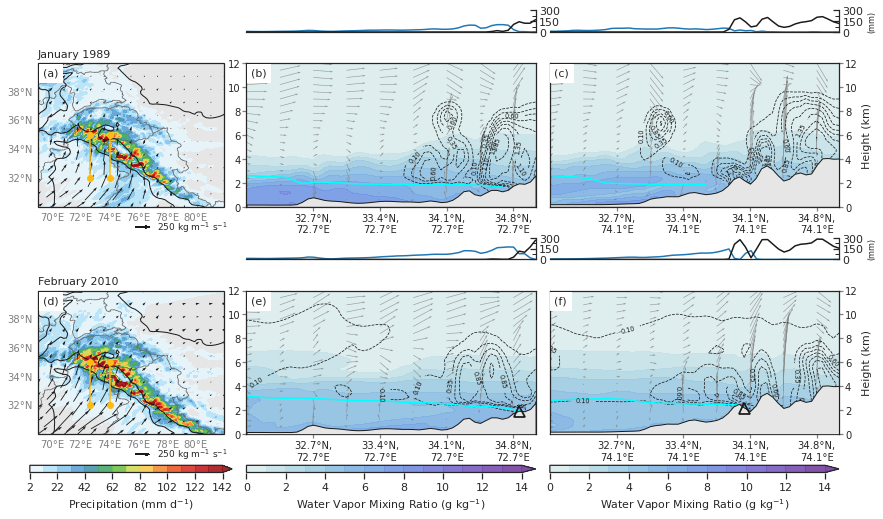

In [9]:
filepath = path_to_figs + 'cross-section_summary_prec_mixing_ratio.png'
## five rows
## 1. precip line plots
## 2. Jan 1989 case 
## 3. precip line plot
## 4. Feb 2010 case
## 5. colorbars
nrows = 5
# three columns - 
## one for synoptic maps, 
## one for vertical cross sections along AR axis
## one for vertical cross sections across AR core
ncols = 3

# Create figure
fig = plt.figure(figsize=(14.5,8.5))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[0.15, 1, 0.15, 1, 0.05], width_ratios = [0.7, 1, 1], hspace=0.46, wspace=0.055)
## use gs[rows index, columns index] to access grids
# Now, create the gridspec structure, as required

#########################
### Precip line plots ###
#########################
latlon_lst = [12, 12, 12, 12]
row_idx = [0, 0, 2, 2]
col_idx = [1, 2, 1, 2]
for j, prec in enumerate(prec_crs):    
    ## Add rain and snow line plot
    ax = fig.add_subplot(gs[row_idx[j], col_idx[j]])

    # WRF Precip
    x = prec.lat.values
    y = prec.rain.values
    ax.plot(x, y, color='tab:blue')
    print('Max line rain:', np.nanmax(y))

    # WRF SNOW
    y = prec.snow.values
    ax.plot(x, y, color='k')
    print('Max line snow:', np.nanmax(y))

    # some plot parameters to make it look nice
    ax.set_ylim(0, 300)
    ax.set_yticks(np.arange(0, 375, 75))
    ax.yaxis.set_major_locator(plt.MultipleLocator(150))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(75))
    ax.yaxis.tick_right()
    ax.tick_params(axis="y",which="both", direction="in")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([x.min(),x.max()])
    
    # ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
#     ax.get_yaxis().set_ticks([])
    ax.patch.set_alpha(0.0)
    
    if (j == 1) | (j == 3):
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_ylabel("(mm)", fontsize=8)
        # ax.yaxis.set_major_locator(plt.MaxNLocator(3))

###################
### precip maps ###
###################
row_idx = [1, 3]
ttl = ['(a)', '(d)']
# point location for (a) (b) (c) label annotation
xpt = 0.027
ypt = 0.965
for i, row in enumerate(row_idx):
    ax = fig.add_subplot(gs[row, 0], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=True, right_lats=False)

    # Contour Filled
    data = prec_lst[i]
    prec = data.values
    lats = data.lat.values
    lons = data.lon.values
    print('Precipitation min/max (mm)', np.nanmin(prec), np.nanmax(prec))
    cflevs = np.arange(2, 152, 10)
    # clipcmap = cmocean.tools.crop_by_percent(cmo.rain, 10, which='max', N=None)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors (IVT)
    data = ivt_lst[i]
    uvec = data.ivtu.values
    vvec = data.ivtv.values
    ivt = data.ivt.values
    ivtlons = data.lon.values
    ivtlats = data.lat.values
    Q = ax.quiver(ivtlons, ivtlats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=12, pivot='middle',
                  angles='xy', scale_units='xy', scale=250, units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.6, -0.14, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 9.0})

    # add all lines and points for the synoptic plot
    add_lines_and_points(ax, terrain)

    # add text title
    ax.text(xpt, ypt, ttl[i], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
    # Row labels
    ax.set_title(row_lbl[i], loc='left', fontsize=11)
    
# Add color bar
cbax = plt.subplot(gs[4,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('Precipitation (mm d$^{-1}$)', fontsize=11)

#####################
### cross-section ###
#####################
ttl = ['(b)', '(c)', '(e)', '(f)']
row_idx = [1, 1, 3, 3]
col_idx = [1, 2, 1, 2]
# point location for (a) (b) (c) label annotation
xpt = 0.015
ypt = 0.965
for j, cross in enumerate(cross_new):
    # vertical cross section plots - across AR

    ax = fig.add_subplot(gs[row_idx[j], col_idx[j]])
    ## use ds.bfill to fill nan values close to mountain range
    cross = cross[0].bfill(dim='vertical', limit=None)
    xs = np.arange(0, len(cross.cross_line_idx), 1)
    ys = cross["vertical"].values/1000.0 #convert to km

    # Fill in the mountain area
    terline = cross.ter.values/1000.0 #convert to km
    ht_fill = ax.fill_between(xs, 0, terline, facecolor='0.9', edgecolor='k', zorder=10)

    # contours
    qice = cross.QSNOW_cross.values*1000 # convert to g kg-1
    print('Ice mixing ratio min/max', qice.min(), qice.max())
    clevs = np.arange(0.1, 2.25, 0.25)
    cs = ax.contour(xs, ys, qice, levels=clevs, 
                    colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
    kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.2f',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels) 

    # Filled contours
    cflevs = np.arange(0, 15., 1.)
    rv_gkg = cross.QVAPOR_cross.values*1000 # convert to g kg-1
    clipcmap = cmocean.tools.crop_by_percent(cmo.dense, 30, which='max', N=None)
    cf = ax.contourf(xs, ys, rv_gkg, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)
    
    # zonal wind vectors
    dw = 6
    ax.quiver(xs[::dw], ys[::dw], cross.ua_cross.values[::dw, ::dw], cross.wa_cross.values[::dw, ::dw]*100, color='grey', alpha=0.8, width=0.002)

    ## add in freezing level height
    y = freeze_crs[j].z.values / 1000. # convert from m to km
    freeze_line = ax.plot(xs, y, c='cyan', lw=1.5)
    
    ## add star to landslide latitude
    if j == 2:
        ax.plot(cross_idx_lst[0][0], terline[cross_idx_lst[0][0]], marker='^', ms=11, mec='k', mfc="None", markeredgewidth=1.75, zorder=101)
    if j == 3:
        ax.plot(cross_idx_lst[0][1], terline[cross_idx_lst[0][1]], marker='^', ms=11, mec='k', mfc="None", markeredgewidth=1.75, zorder=101)

    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = cross.coords["xy_loc"].values
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
    # set the frequency of xtick labels
    skip = latlon_lst[j]
    ax.set_xticks(x_ticks[12::skip])
    ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[12::skip]], fontsize=10)
    
    # add text title
    ax.text(xpt, ypt, ttl[j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    # Set the yaxis label
    if (j == 1) | (j == 3):
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_ylabel("Height (km)", fontsize=11)

    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=10, 
                   length=4, 
                   pad=2, 
                   color='gray')
    
    if j < 2:
        # Add color bar
        cbax = plt.subplot(gs[4,j+1]) # colorbar axis
        cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
        cb.set_label('Water Vapor Mixing Ratio (g kg$^{-1}$)', fontsize=11)
    
## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
